# Fitting stationary time series with tensorflow

This document describes how to fit models for stationary time series to data. We'll do this in tensorflow to take advantage of the build in differentiation and optimization algorithms. Before we start we'll make a conceptual detour to motivate the implementation.

In this document we'll denote the stationary time series of interest with $s$. $s$ has $N$ components that we refer to as $s_i$, where $i = 1\ldots N$. We'll also make use of the variable $\epsilon$ to denote a time series of length $N$ with independent and identically distributed (iid) components $\epsilon_i$. In our particular examples the $\epsilon_i$ will follow a standard normal distribution.

We are interested in the probability of a time-series which according to the probability chain rule can be written as follows
$$
\begin{aligned}
 P(s_n,s_{n-1},\ldots,s_2,s_1) &= \prod_{i=1}^N P(s_i|s_{i-1},\ldots,s_1) \\
  &= \prod_{i=1}^N P(s_i|i-1)
\end{aligned}
$$
where we defined the shorthand notation 
$$
\begin{aligned}
P(s_i|i-1) &= P(s_i|s_{i-1},\ldots,s_1), \\
P(s_1 | 0) &= P(s_1).
\end{aligned}
$$

While this decomposition is valid for any joint probability distribution it is particularly useful for the analysis of time series that are quite naturally and therefore also quite often modeled in this manner. Instead of the probability defined above its negative logarithm is often used in practice. We define this quantity of interest as follows
$$\mathrm{NLL}(s) = -\sum_{i=1}^N \log P(s_i|i-1).$$
This quantity is called the negative log likelyhood (nll).
A common parameter estimation technique is the maximum likelyhood technique, which is equivalent to minimizing the nll.

Many time series models are designed such that the distributions $P(s_i|i-1)$ are of the same type for all
$i$, but with possibly $i$ dependent parameters. In this document we'll consider the concrete example of
the normal distribution
$$P(s_i|i-1) = N(s_i;\mu_i,\sigma_i^2), $$
where each $s_i$ is normally distributed by with possibly $i$-dependent mean and variance. Once the $\mu_i$ and the $\sigma_i$ are known the nll can be calculated easily as
$$\mathrm{NLL}(s) = -\sum_{i=1}^N \log N(s_i;\mu_i,\sigma_i^2). $$
And we demonstrate now how this is done in tensorflow.

In [1]:
import tensorflow as tf
import numpy as np

/home/kami/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#An example of random numbers thaht we'll be using
N = 250
epsilon_example= np.random.normal(size=N)


def negativeLogLikelyhood(observations,mu=0.0,sigma=1.0):
    """
    Negative log likelyhood for observations that are conditionally normal with mean mu and
    standard deviation sigma. Here mu and sigma can be either floats (constant for all observations)
    or tensorflow tensorsof the same size as the observations tensor.
    """
    dist = tf.distributions.Normal(loc = mu,scale = sigma)
    return tf.negative(tf.reduce_sum(dist.log_prob(observations)))

#minimal example for using the loglikelyhood function
iidSeries = tf.placeholder(tf.float32)
ll = negativeLogLikelyhood(iidSeries)
with tf.Session() as sess:
    evaluated_ll = sess.run(ll,feed_dict={iidSeries : epsilon_example/100})
    
print("Negative Log Likelyhood: ",evaluated_ll)

Negative Log Likelyhood:  229.74933


Now in order for this to be useful we have to determine $\mu_i$ and $\sigma_i$ for the time series models of interest. We illustrate this for two examples of common models. It is particularly important to express the $\mu_i$ and $\sigma_i$ in terms of observed quantities and we'll illustrate this in one of our examples.

#### ARMA(1,1) Model
$$s_i = \epsilon_i + q\epsilon_{i-1} + ps_{i-1} $$ Parameters are $p$, $q$ and $\mu_1$ (starting point of the regression). The $\epsilon_{i-1}$ are unobserved iid normal variables and therefore $P(s_i|i-1)$ is a shifted and scaled normal distribution. We have
$$ P(s_i|i-1) = N(s_i;\mu_i = q\epsilon_{i-1} + ps_{i-1};\sigma_i^2 = 1) $$
While the distribution is correct $\mu_i$ depends on the unobserved quantity $\epsilon_{i-1}.$
In order to deal with this we solve the defining ARMA equation for $\epsilon$ and get $\epsilon_{i-1} = q\epsilon_{i-2} + ps_{i-2} - s_{i-1}$. This can be recursively substituted with the initial condition $\epsilon_1 = \mu_1 - s_1$ to obtain an expression for $\mu_i$ that only depends on observable data.

#### GARCH(1,1) Model
$$
\begin{aligned}
 \sigma_i^2 &= \omega + qs_{i-1}^2 + p\sigma_{i-1}^2 \\
 s_i &= \sigma_i\epsilon_i
\end{aligned}
$$
The parameters are $\omega$, $q$, $p$ and $\sigma_1$. This formulation fits directly into the presented framework, and we get
$$  P(s_i|i-1) = N(s_i;\mu_i = 0;\sigma_i^2 = \omega + qs_{i-1}^2 + p\sigma_{i-1}^2). $$
Similarly to how the unobservable quantity $\epsilon_i$ needed to be calculated recursively in the ARMA
model, the unobservable quantity $\sigma_i$ needs to be calculated recursively in the GARCH model.

As an example we consider a simple GARCH(1,1) model with parameters
- $\omega = 0.1$
- $p = 0.2$
- $q =0.6$
- $\sigma_1 = 0.25$

We create a simulation sample of this GARCH(1,1) time series in numpy:

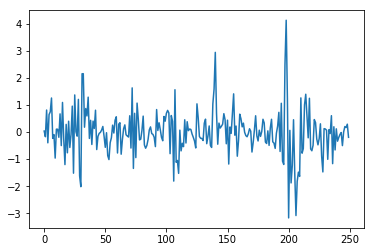

In [3]:
omega = 0.1
p = 0.2
q = 0.6
sigma1 = 0.25

sigmas = np.zeros_like(epsilon_example)
s_garch_example = np.zeros_like(epsilon_example)


for timestep in range(len(epsilon_example)):
    if (timestep > 0):
        sigmas[timestep] = np.sqrt(omega + q*s_garch_example[timestep-1]**2 + p*sigmas[timestep-1]**2)
    else:
        sigmas[timestep] = sigma1
    s_garch_example[timestep] = sigmas[timestep]*epsilon_example[timestep]
    
    
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(s_garch_example)
plt.show()

We now show how to fit this time series in tensorflow using the outlined strategy. We use the definition of the time series model to determine the series for $\mu_i$ and $\sigma_1$ and then calculate nll using the function defined above. We then use tensorflow's build in functionality to minimize this function.

In [4]:
def garch_1_1_nll(s_observations,omega,q,p,sigma1,N):
    sigma_list = []
    
    #loop over observations, where enumerate is used to identify the first observation
    #looping over the contents of a tensor can be a little tricky. One way is to unstack
    #the 1 dimensional tensor into an iterable of 0 dimensional tensors using unstack.
    #the disadvantage is, that the size of the unstacking dimension has to be known
    #in advance.
    for (timestep,s_timestep) in enumerate(tf.unstack(s_observations,num=N)):
        if (timestep > 0):
            current_sigma = tf.sqrt(omega + q*tf.square(prev_s) + p*tf.square(prev_sigma))
            
        else:
            current_sigma = sigma1
        
        prev_sigma = current_sigma
        prev_s = s_timestep
        sigma_list.append(current_sigma)
        
    sigmas = tf.stack(sigma_list)
    nll = negativeLogLikelyhood(s_observations,sigma=sigmas)
    return nll


s_observations = tf.placeholder(tf.float32,shape = [None])

#A typical appreach for initializing the sigma1 and omega are sample stdandard deviation and variance
sigma1_tensor = tf.Variable(np.float32(np.std(s_garch_example)))
omega_tensor = tf.Variable(np.float32(np.var(s_garch_example)))


q_tensor = tf.Variable(0.5)
p_tensor = tf.Variable(0.5)


garch_nll = garch_1_1_nll(s_observations,
                                omega=omega_tensor,
                                q=q_tensor,
                                p=p_tensor,
                                sigma1 = sigma1_tensor,
                                N=N)

In [14]:
optimizer = tf.train.MomentumOptimizer(learning_rate=0.00001,momentum=0.9)
traning_op = optimizer.minimize(garch_nll)

nll_list =[]
init = tf.global_variables_initializer()
with tf.Session() as sess:
    init.run()
    
    #minimizartion iterations
    for _ in range(100):        
        _,evaluated_garch_nll = sess.run((traning_op,garch_nll),feed_dict = {s_observations:s_garch_example})
        nll_list.append(evaluated_garch_nll)
        
    (omega_est,q_est,p_est,sigma1_est) = sess.run((omega_tensor,q_tensor,p_tensor,sigma1_tensor),feed_dict = {s_observations:s_garch_example})
    

omega true:  0.1  estimate:  0.15995373 
q true:  0.6  estimate:  0.52995974 
p true:  0.2  estimate:  0.17396545 
sigma1 ture:  0.25  estimate:  0.8208314


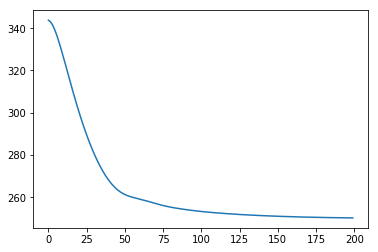

In [15]:
print('omega true: ',omega,' estimate: ',omega_est,
      '\nq true: ',q,' estimate: ',q_est,
      '\np true: ',p,' estimate: ',p_est,
      '\nsigma1 ture: ',sigma1,' estimate: ',sigma1_est)
plt.plot(ll_list)